In [100]:
import sqlite3
import pandas as pd
import numpy as np
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from datetime import datetime, timedelta

In [46]:
db = sqlite3.connect('trade_info.sqlite3')
chart_data = pd.read_sql_query("SELECT * FROM chart_data", db)
trading_session = pd.read_sql_query("SELECT * FROM trading_session", db)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:840: UserWarning: The following variables cannot be serialized: db
  warnings.warn(message)


In [66]:
chart_data

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279
...,...,...,...,...,...,...
5503,5503,12:59:21,15,278,4611,1.946171
5504,5504,11:01:06,179,279,4612,1.128045
5505,5505,11:01:06,300,279,4613,1.128045
5506,5506,11:01:06,20,279,4614,1.128045


In [67]:
trading_session

,id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2
...,...,...,...,...
260,275,2021-06-22,daily,1
261,276,2021-06-22,daily,2
262,277,2021-06-23,monthly,1
263,278,2021-06-23,monthly,2


In [63]:
all_data = pd.read_sql_query("SELECT * FROM chart_data INNER JOIN trading_session ON chart_data.session_id = trading_session.id", db)
all_data['datetime'] = pd.to_datetime(all_data[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
all_data = all_data.iloc[:, [j for j, c in enumerate(all_data.columns) if j not in [1, 6, 7]]]
all_data = all_data.sort_values(['datetime', 'deal_id', 'id'])
all_data = all_data.drop_duplicates(subset=['deal_id', 'trading_type', 'platform_id'], keep='first')

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:840: UserWarning:

The following variables cannot be serialized: db



In [94]:
pd.set_option("display.max_rows", 10)
all_data

,id,lot_size,session_id,deal_id,price,trading_type,platform_id,datetime
879,1114,1,35,688,-0.735466,monthly,1,2019-02-21 11:05:02
880,1115,1,36,689,-1.129379,monthly,2,2019-02-21 11:05:02
691,926,17,39,647,-0.765767,monthly,1,2019-03-22 11:05:02
692,927,16,39,648,-0.765767,monthly,1,2019-03-22 11:05:02
693,928,4,39,649,-0.765767,monthly,1,2019-03-22 11:05:02
...,...,...,...,...,...,...,...,...
5268,5503,15,278,4611,1.946171,monthly,2,2021-06-23 12:59:21
5269,5504,179,279,4612,1.128045,daily,1,2021-06-24 11:01:06
5270,5505,300,279,4613,1.128045,daily,1,2021-06-24 11:01:06
5271,5506,20,279,4614,1.128045,daily,1,2021-06-24 11:01:06


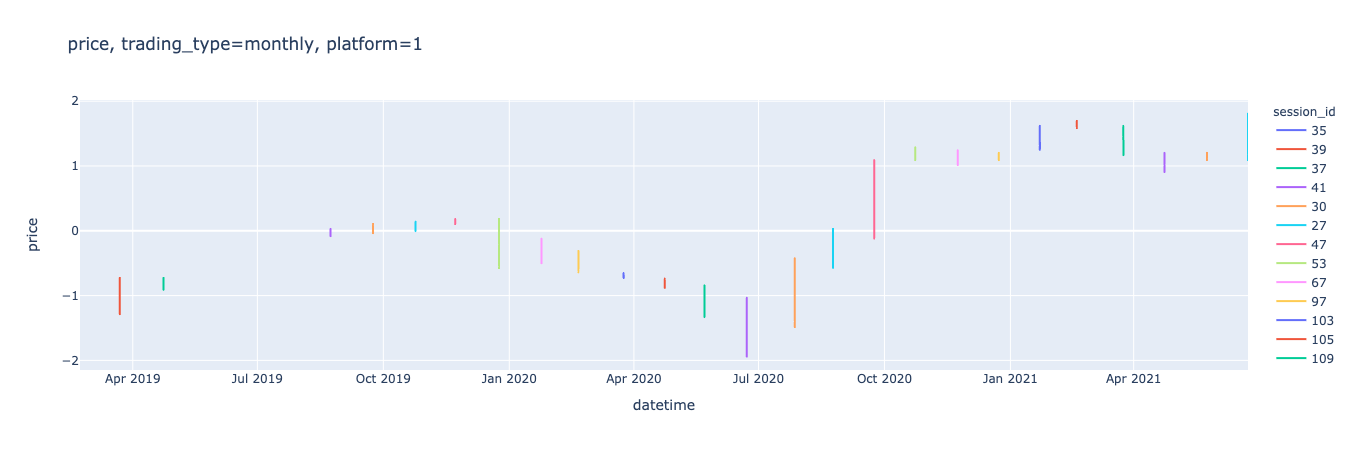

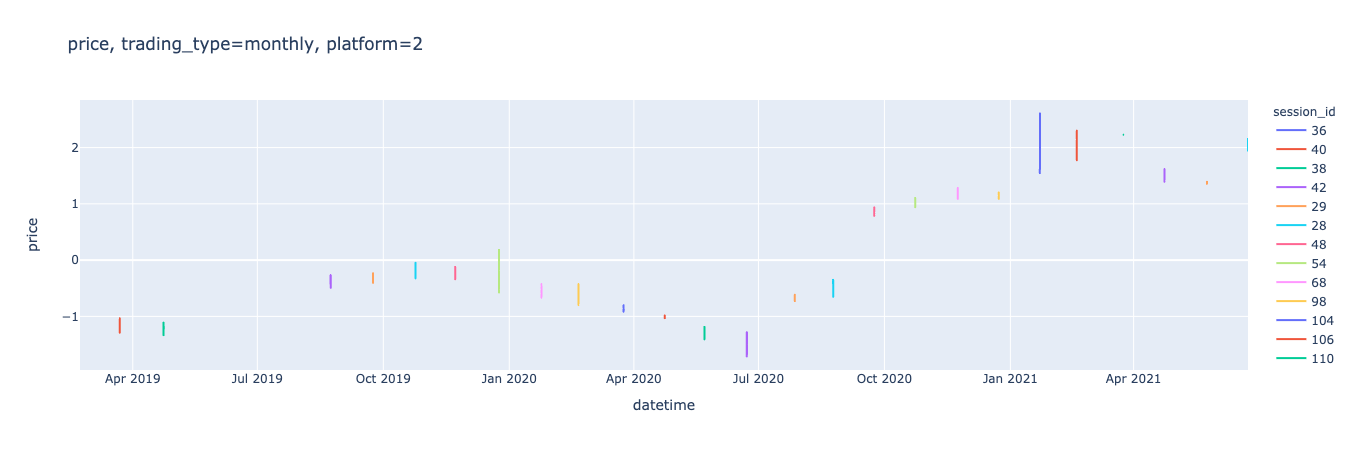

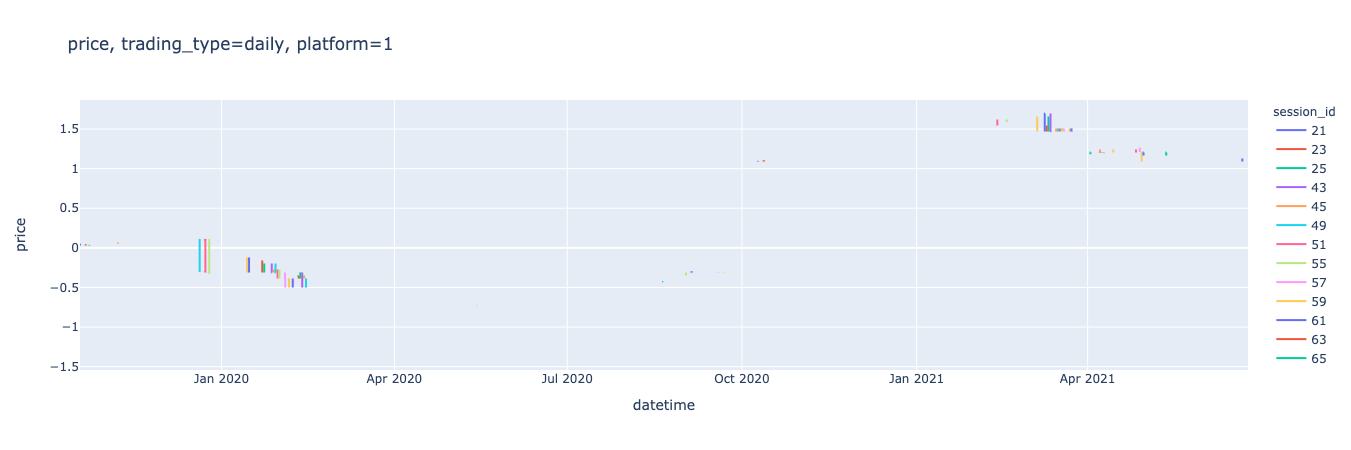

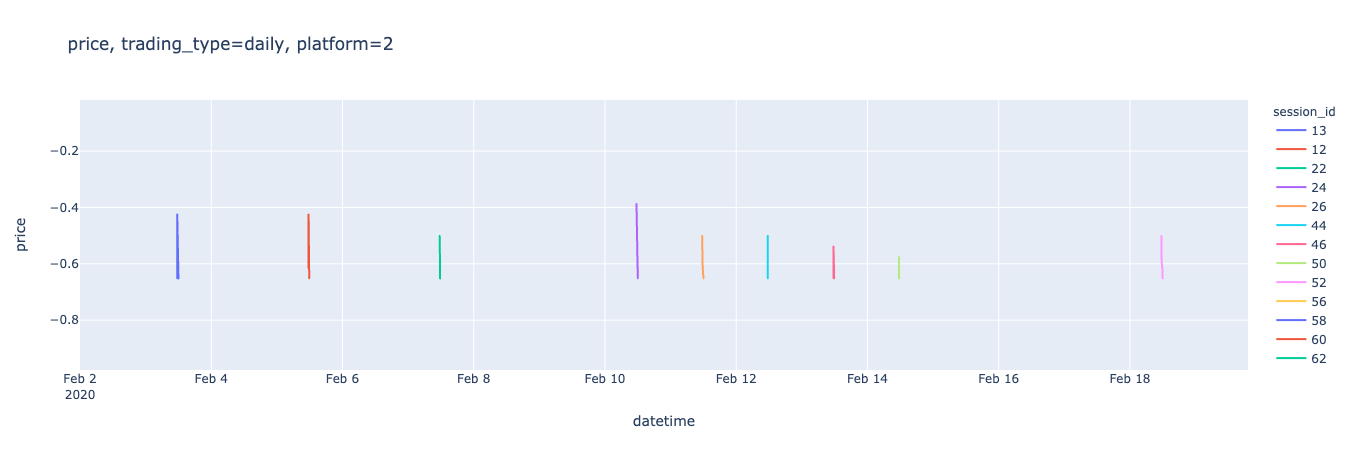

In [76]:
for trading_type in ['monthly', 'daily']:
    for platform_id in [1, 2]:
        df = all_data[(all_data['trading_type'] == trading_type) & (all_data['platform_id'] == platform_id)]
        fig = px.line(df, x='datetime', y='price', color='session_id', title=f'price, trading_type={trading_type}, platform={platform_id}')
        fig.show()

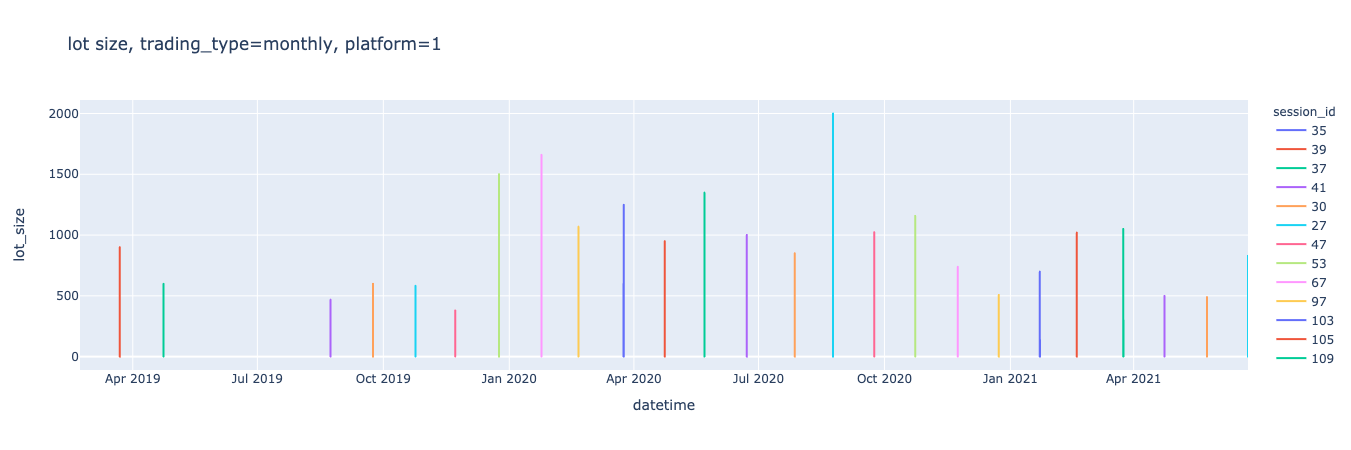

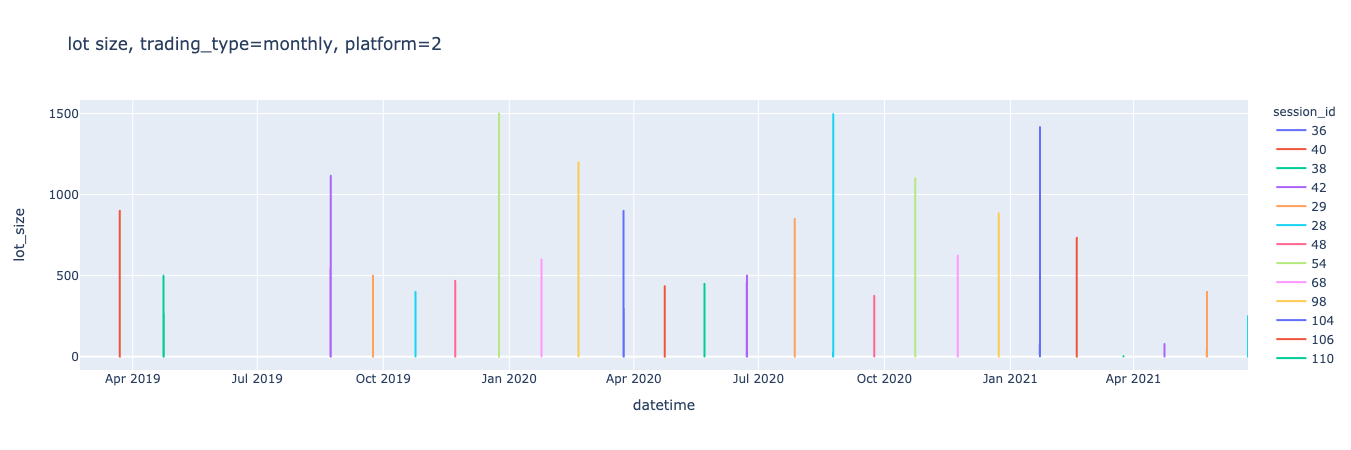

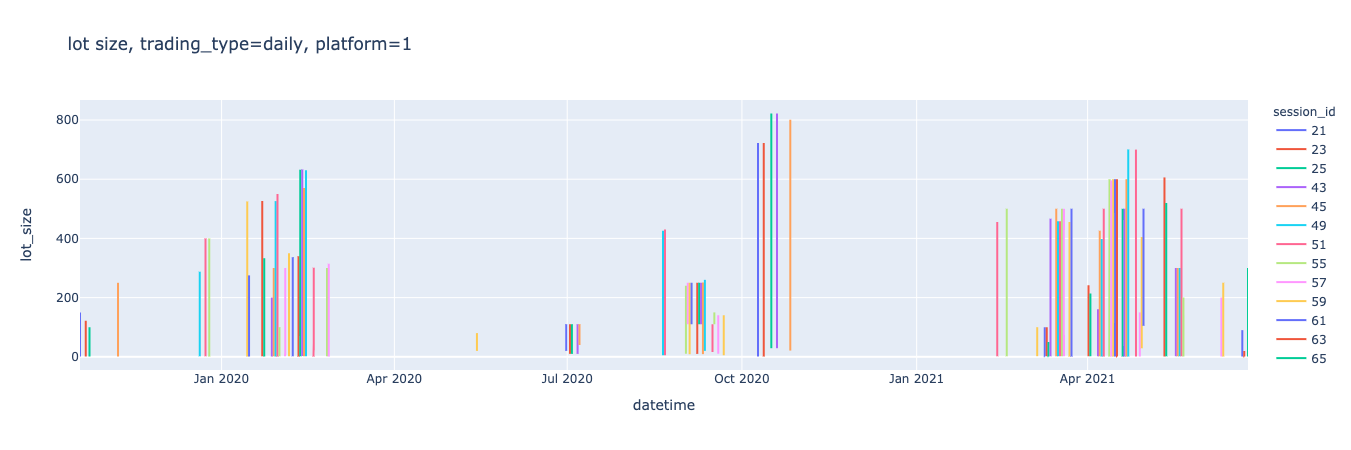

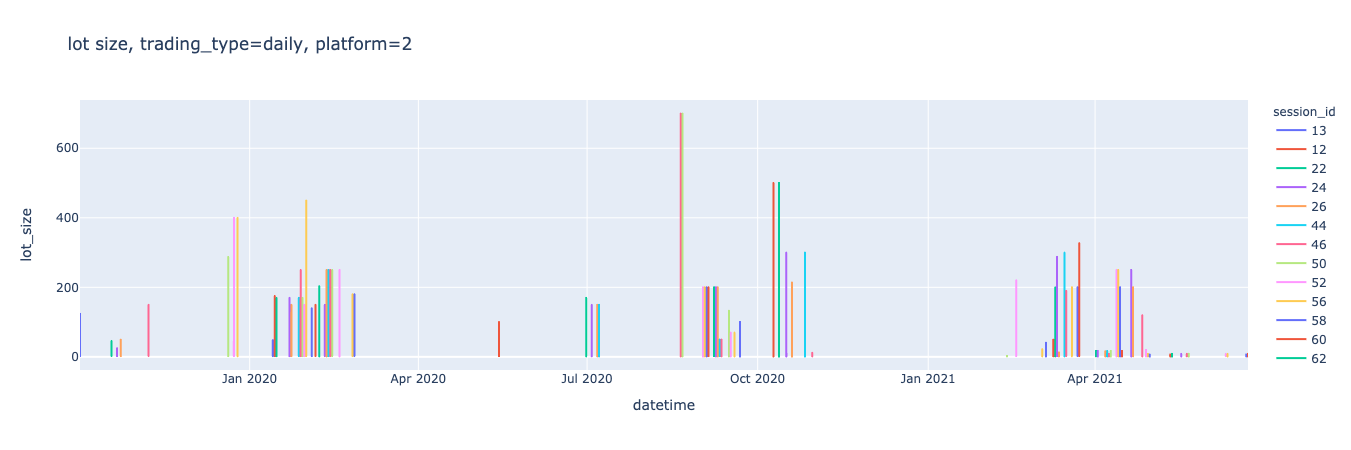

In [77]:
for trading_type in ['monthly', 'daily']:
    for platform_id in [1, 2]:
        df = all_data[(all_data['trading_type'] == trading_type) & (all_data['platform_id'] == platform_id)]
        fig = px.line(df, x='datetime', y='lot_size', color='session_id', title=f'lot size, trading_type={trading_type}, platform={platform_id}')
        fig.show()

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



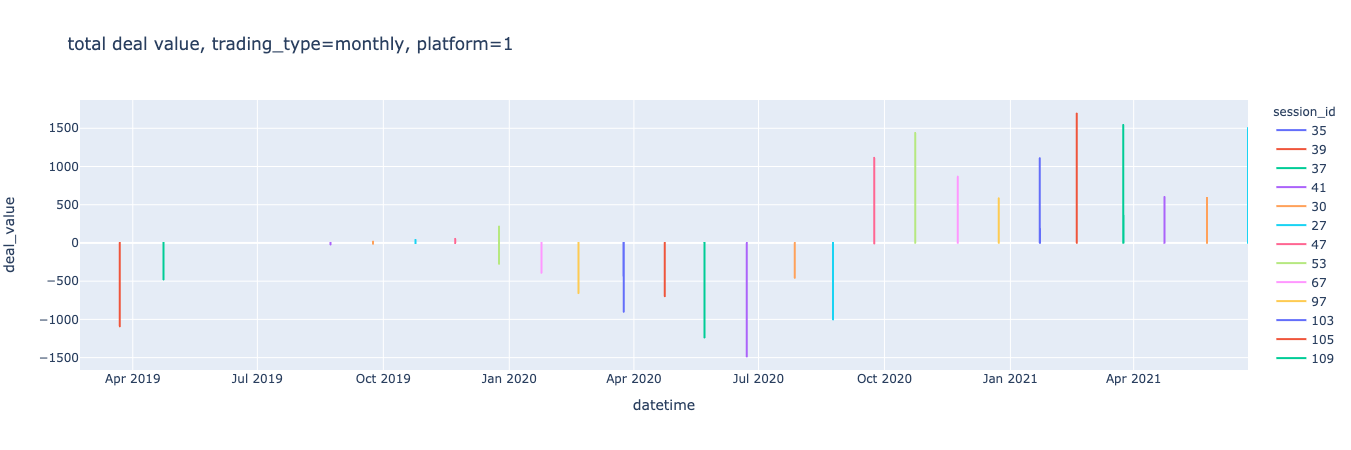

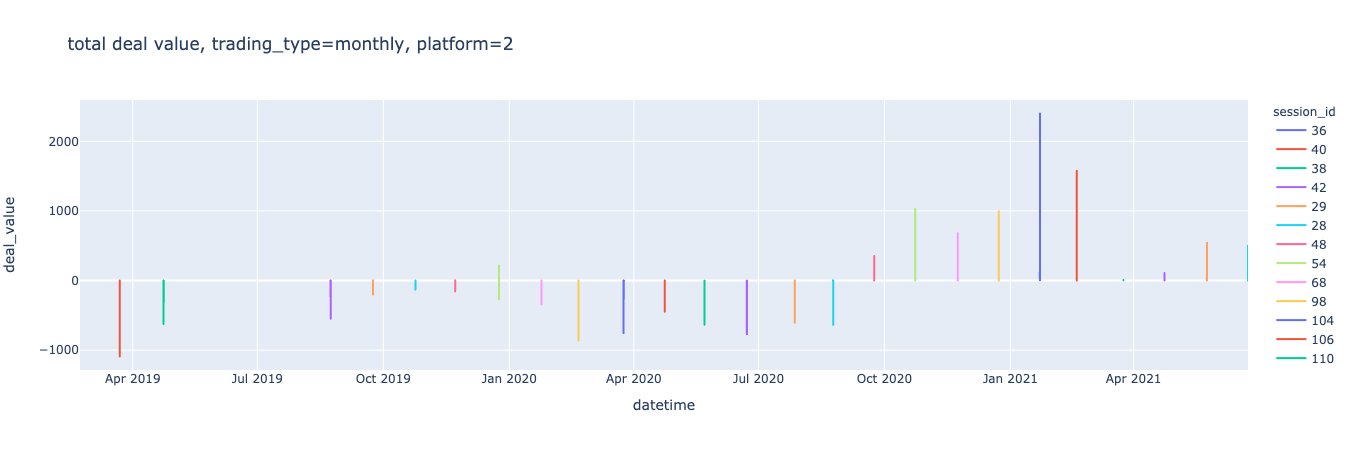

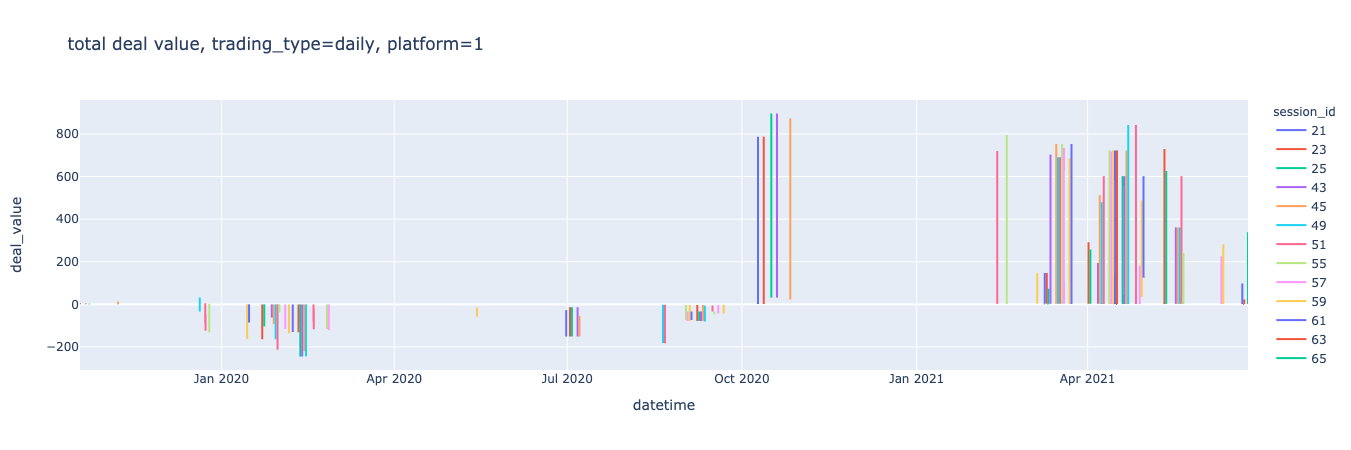

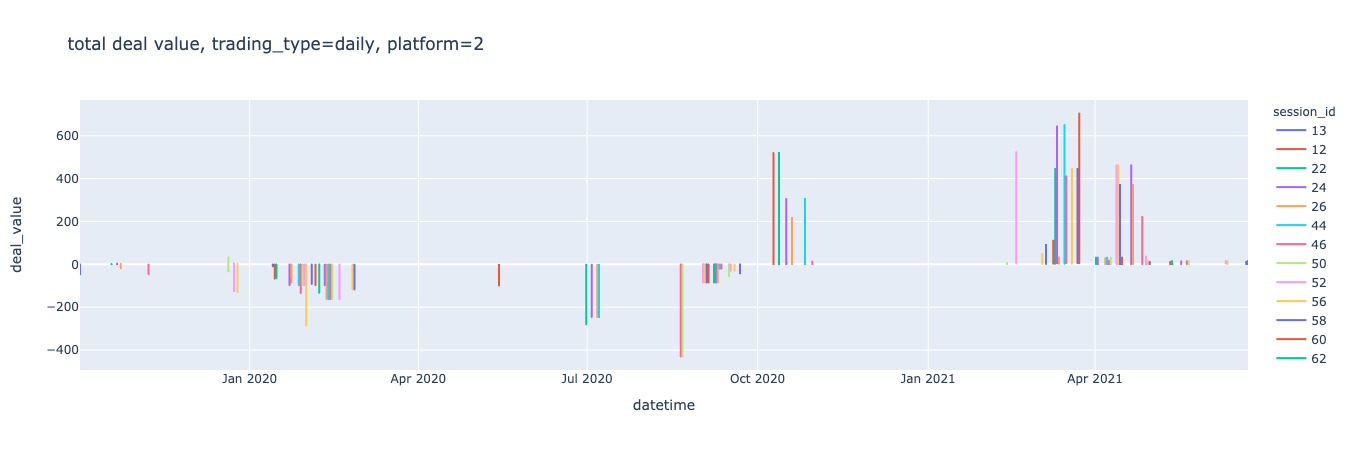

In [75]:
for trading_type in ['monthly', 'daily']:
    for platform_id in [1, 2]:
        df = all_data[(all_data['trading_type'] == trading_type) & (all_data['platform_id'] == platform_id)]
        df['deal_value'] = df['lot_size'] * df['price']
        fig = px.line(df, x='datetime', y='deal_value', color='session_id', title=f'total deal value, trading_type={trading_type}, platform={platform_id}')
        fig.show()

In [102]:
sessions = set(all_data['session_id'].to_list())
bad_sessions = set()
for session in sessions:
    df = all_data[all_data['session_id'] == session]
    delta = timedelta(hours=1) if df['trading_type'].iloc[0] == 'monthly' else timedelta(minutes=30)
    t0 = df['datetime'].iloc[0]
    t1 = df['datetime'].iloc[-1]
    if t1 - t0 > delta and t0.minute <= t1.minute:
        bad_sessions.add(session)

all_data = all_data[all_data['session_id'].apply(lambda x: x not in bad_sessions)]

In [103]:
all_data

,id,lot_size,session_id,deal_id,price,trading_type,platform_id,datetime
879,1114,1,35,688,-0.735466,monthly,1,2019-02-21 11:05:02
880,1115,1,36,689,-1.129379,monthly,2,2019-02-21 11:05:02
773,1008,10,40,541,-1.030901,monthly,2,2019-03-22 12:03:45
774,1009,1,40,542,-1.030901,monthly,2,2019-03-22 12:03:45
775,1010,1,40,543,-1.030901,monthly,2,2019-03-22 12:07:59
...,...,...,...,...,...,...,...,...
5268,5503,15,278,4611,1.946171,monthly,2,2021-06-23 12:59:21
5269,5504,179,279,4612,1.128045,daily,1,2021-06-24 11:01:06
5270,5505,300,279,4613,1.128045,daily,1,2021-06-24 11:01:06
5271,5506,20,279,4614,1.128045,daily,1,2021-06-24 11:01:06


In [104]:
def session_embedding(df, n):
    deals = np.zeros(n)
    lots = np.zeros(n)
    mask = np.zeros(n, dtype=bool)
    for _, row in df.iterrows():
        t = row['datetime'].minute % n
        deals[t] += row['price'] * row['lot_size']
        lots[t] += row['lot_size']
        mask[t] = True
    
    emb = np.zeros(n)
    last_price = df['price'].iloc[0]
    
    for i in range(n):
        if not mask[i]:
            emb[i] = last_price
        else:
            emb[i] = deals[i] / lots[i]
            last_price = emb[i]
            
    return emb

In [105]:
stats = []
for trading_type in ['monthly', 'daily']:
    for platform_id in [1, 2]:
        df = all_data[(all_data['trading_type'] == trading_type) & (all_data['platform_id'] == platform_id)]
        sessions = set(df['session_id'].to_list())
        for session_id in sessions:
            sub_df = df[df['session_id'] == session_id]
            n = 60 if trading_type == 'monthly' else 30
            stat = {'trading_type': trading_type, 'platform_id': platform_id, 'session_id': session_id, 'embedding': session_embedding(sub_df, n)}
            stats.append(stat)